# Recruitment Task: Classification of a Heart with Hypertrophic Cardiomyopathy

I'm going to prepare a solution classification problem of detecting hypertrophic cardiomyopathy based on the provided features. The goal is to build a model capable of correctly distinguishing between a healthy heart and a diseased heart. I'll use: 
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier

## Dataset Attributes

- **Cardiomegaly** :  indicates whether the heart was diagnosed with cardiomegaly:
    - 1 – positive diagnosis (diseased heart)
    - 0 – negative diagnosis (healthy heart)

- **Heart width** - The maximum horizontal width of the heart.

- **Lung width** - The horizontal distance between the outermost points of the lungs.

- **Inertia tensors** - Metrics describing the distribution of heart and lung pixels relative to the coordinate axes, capturing the shape and orientation of the objects.
    - xx – distribution of pixels relative to the y-axis (elongation along x)
    - yy – distribution of pixels relative to the x-axis (elongation along y)
    - xy – distribution relative to both x and y axes (a high value indicates object rotation)
    - normalized_diff – a scalar value derived from the vector whose components are described above
    
- **Inscribed circle radius** - The radius of the largest circle that can be inscribed within the heart area, describing its symmetry and compactness.

- **Polygon area ratio** - The ratio of the area of the polygon enclosing the heart contour to the actual heart area.

- **Heart perimeter** - The length of the heart contour.

- **Heart area** - The area occupied by the heart.

- **Lung area** - The area occupied by the lungs.

- **CR ratio** - The ratio of heart width to lung width.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

## Data overview

In [2]:
# Load the data
df = pd.read_csv("task_data.csv")

df.head()

,ID,Cardiomegaly,Heart width,Lung width,CTR - Cardiothoracic Ratio,xx,yy,xy,normalized_diff,Inscribed circle radius,Polygon Area Ratio,Heart perimeter,Heart area,Lung area
0,1,0,172,405,"0,424691358",1682.360871,3153.671880,-638.531109,-0.304239,"68,8186",0.213446,"679,4873689",24898,75419
1,2,1,159,391,"0,4066496164",1526.660960,5102.159054,-889.678405,-0.539387,"73,92564",0.203652,"788,6589419",29851,94494
2,5,0,208,400,"0,52",2465.903392,5376.834707,-1755.344699,-0.371163,"69,33974",0.320787,"862,3229369",33653,66666
3,7,1,226,435,"0,5195402299",2509.063593,6129.821270,-1025.079806,-0.419123,"84,14868",0.317545,"906,724959",42018,82596
4,8,1,211,420,"0,5023809524",2368.770135,5441.767075,-1493.040062,-0.393442,"73,78347",0.263542,"864,2396777",35346,85631


In [3]:
# Displays data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     object 
 5   xx                          37 non-null     float64
 6   yy                          37 non-null     float64
 7   xy                          37 non-null     float64
 8   normalized_diff             37 non-null     float64
 9   Inscribed circle radius     37 non-null     object 
 10  Polygon Area Ratio          37 non-null     float64
 11  Heart perimeter             37 non-null     object 
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

columns : CTR - Cardiothoracic Ratio, Inscribed circle radius, Heart perimeter are object type, they need to be converted to a float type.

In [4]:
# replaces ',' with '.' and then converting to a float type
cols = ["CTR - Cardiothoracic Ratio", "Inscribed circle radius", "Heart perimeter"]

df[cols] = (
    df[cols]
    .replace(",", ".", regex=True)  
    .astype(float)                    
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     float64
 5   xx                          37 non-null     float64
 6   yy                          37 non-null     float64
 7   xy                          37 non-null     float64
 8   normalized_diff             37 non-null     float64
 9   Inscribed circle radius     37 non-null     float64
 10  Polygon Area Ratio          37 non-null     float64
 11  Heart perimeter             37 non-null     float64
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

Now each column is numeric type.

## Feature Engineering
As a part of feature engineering, I added 3 derivative indicators:
- **Rotation index** - describes the orientation of the heart.
    $$
    Rotation = \frac{xy}{\,|xx| + |yy| + \varepsilon\,}
    $$
- **Asymmetry index** - measures the degree of cardiac asymmetry.
    $$
    Asymmetry = \frac{xx - yy}{\,xx + yy + \varepsilon\,}
    $$
- **Deformation index** - describes the degree of deformation.
    $$
    Deformation = \frac{\text{normalized\_diff} \cdot (xx + yy)}{\,|xx| + |yy| + \varepsilon\,}
    $$

In [6]:
eps = 1e-6 # Number that protects against division by zero and numerical instabilities

df["rotation_index"] = df["xy"] / (np.abs(df["xx"]) + np.abs(df["yy"]) + eps)

df["asymmetry_index"] = (df["xx"] - df["yy"]) / (df["xx"] + df["yy"] + eps)

df["deformation_index"] = df["normalized_diff"] * (df["xx"] + df["yy"]) / (np.abs(df["xx"]) + np.abs(df["yy"]) + eps)

## Modeling

In [7]:
# Key feature selection

X = df[["CTR - Cardiothoracic Ratio", "Inscribed circle radius", "Polygon Area Ratio", "Heart perimeter", "rotation_index", "asymmetry_index", "deformation_index"]]
y = df["Cardiomegaly"]

# Split dataset into train/test sets 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Evaluation Methods

In [8]:
# Evaluate model with cross-validation, training, test metrics, and classification report

def evaluate_model(model):
    cv_scores = np.round(cross_val_score(model, X_train, y_train, cv=5),2)

    print("Scores of training data cross-validation (each fold):")
    list(map(print, cv_scores))
    print(f"\nCross-validation mean score: {cv_scores.mean():.3f}")
    print(f"Standard deviation of CV score: {cv_scores.std():.3f}\n")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    print("Classification performance metrics: ")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_score):.3f}\n")

    print("Classification report: ")
    print(classification_report(y_test, y_pred))

Function **evaluate_model()** evaluates the model by performing:
- 5-fold cross-validation and summary of results: mean, std.
- Training the model.
- Prediction on the test set and calculation of metrics: accuracy, ROC-AUC.
- Displaying the classification report.

In [9]:
# Plot ROC curve, Precision-Recall curve and confusion matrix

def plot_metrics(model):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    prec, rec, _ = precision_recall_curve(y_test, y_score)
    plt.plot(rec, prec)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.show()

Function **plot_metrics()** visualizes the model's performance by generating:
- ROC Curve with AUC value,
- Precision-Recall curve,
- Confusion Matrix

## Logistic Regression

In [21]:
# Pipeline with scaling and logistic regression

pipe_log = Pipeline(steps=[
    ("scaler", StandardScaler()),   # Standardizing features to have a mean: 0 and a standard deviation: 1
    ("model", LogisticRegression())
])

evaluate_model(pipe_log)

Scores of training data cross-validation (each fold):
0.83
0.83
0.83
0.83
0.8

Cross-validation mean score: 0.824
Standard deviation of CV score: 0.012

Classification performance metrics: 
Accuracy: 0.750
ROC-AUC: 0.750

Classification report: 
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.83      0.83      0.83         6

    accuracy                           0.75         8
   macro avg       0.67      0.67      0.67         8
weighted avg       0.75      0.75      0.75         8



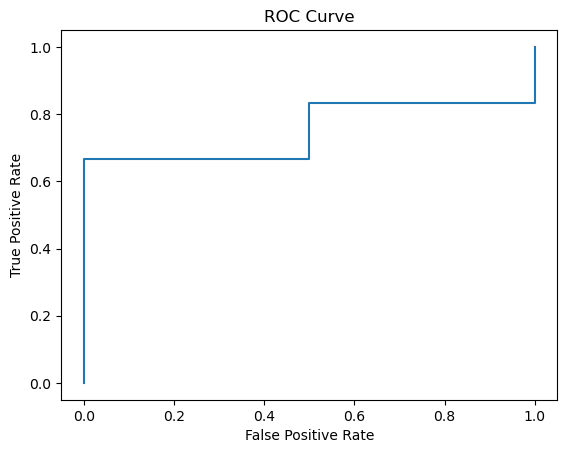

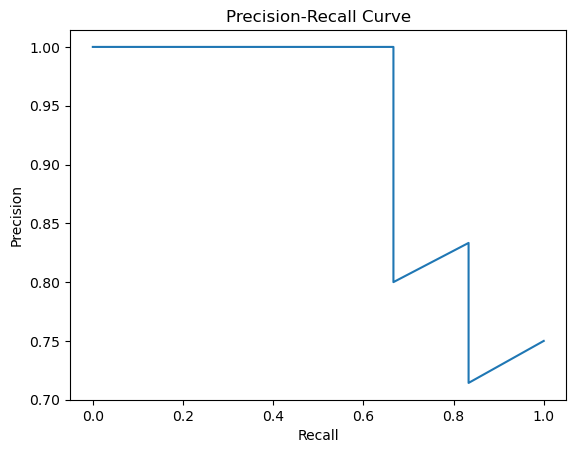

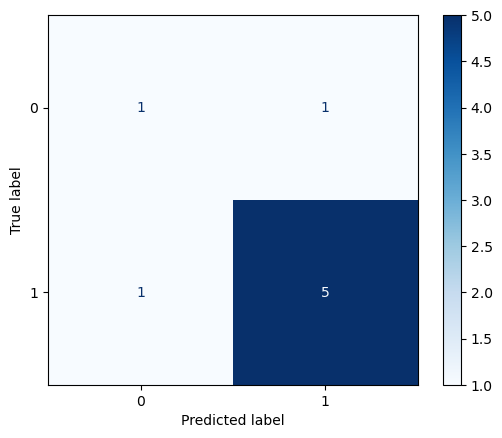

In [22]:
plot_metrics(pipe_log)